In [1]:
# CONDA: tnt
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)
# Don't display scientific  numbers in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import helpers as h
import seaborn as sns
reload(h)

/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_64685/1305254466.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<module 'helpers' from '/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Preprocessing/helpers.py'>

In [2]:
reload(h)

empatica_df = pd.read_csv('output/empatica_combined_raw.csv')
inquisit_df = pd.read_csv('output/inquisit_combined_raw.csv')

# merged_df = h.merge_inquisit_empatica(empatica_df, inquisit_df)

# merged_df.to_csv('output/empatica_inquisit_merged.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'output/empatica_combined_raw.csv'

In [14]:
print(merged_df.head(200))

print("RESPONSE COUNTS")
print(merged_df['response'].value_counts())

print("INTRUSION COUNTS")
print(merged_df['intrusion'].value_counts())

print("TRIALCODE COUNTS")
print(merged_df['trialcode'].value_counts())

         acc_x      acc_y      acc_z         hr   temp       eda         bvp                          time trialcode  response  intrusion
0    -9.285870  42.936198  43.831382  80.814292  26.45  0.026906    4.118854 2023-03-22 12:05:18.000000000      None         0          0
1    -5.732297  46.785212  43.438090  90.170361  26.45  0.026906  -26.130442 2023-03-22 12:05:18.249999872      None         0          0
2    -2.237697  43.976816  44.922013  92.425688  26.45  0.028188   14.419979 2023-03-22 12:05:18.500000000      None         0          0
3    -4.673917  44.903054  45.332522  89.400447  26.45  0.028188   10.727726 2023-03-22 12:05:18.750000128      None         0          0
4    -7.575088  44.367411  43.601637  84.108272  26.13  0.026906  -17.376916 2023-03-22 12:05:19.000000000      None         0          0
5    -6.491830  46.376364  41.866929  79.568219  26.13  0.026906   -0.065494 2023-03-22 12:05:19.249999872      None         0          0
6   -11.314788  45.103205  42.3477

trialcode        response
TNT_NoThink_CSm  0           418
                 1           210
                 2            10
TNT_NoThink_CSp  0           433
                 1           184
                 2             6
TNT_Think_CSm    2           550
                 0            74
                 1            24
TNT_Think_CSp    2           504
                 0           125
                 1            20
Name: response, dtype: int64


<Axes: xlabel='trialcode'>

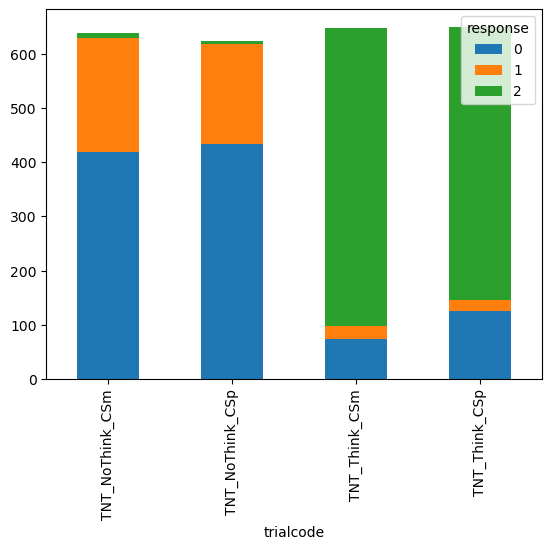

In [16]:
# Plot response counts per trialcode

trialcode_counts = merged_df.groupby('trialcode')['response'].value_counts()
print(trialcode_counts)

trialcode_counts.unstack().plot(kind='bar', stacked=True)


## With IBI / windowed data

In [57]:
reload(h)

empatica_df = pd.read_csv('output/empatica_raw_with_peaks.csv')
inquisit_df = pd.read_csv('output/inquisit_combined_raw.csv')

# merged_df = h.merge_inquisit_empatica(empatica_df, inquisit_df)
# merged_df.to_csv('output/empatica_inquisit_merged.csv', index=False)

In [4]:
empatica_df.head()

,acc_x,acc_y,acc_z,temp,eda,bvp,hr,datetime,unix_time,source,peaks,peaks_per_10s
0,-8.000,46.000,48.000,26.450,0.027,61.930,85.000,2023-03-22 12:05:18.000000,1679486718.000,pp3-d1-1,NaN,NaN
1,-7.407,46.880,50.649,26.466,0.025,90.600,84.979,2023-03-22 12:05:18.015625,1679486718.016,pp3-d1-1,NaN,NaN
2,-6.000,46.000,47.000,26.480,0.022,100.070,84.952,2023-03-22 12:05:18.031250,1679486718.031,pp3-d1-1,NaN,NaN
3,-5.865,44.045,42.881,26.493,0.020,89.910,84.919,2023-03-22 12:05:18.046875,1679486718.047,pp3-d1-1,NaN,NaN
4,-7.000,44.000,43.000,26.503,0.018,64.680,84.881,2023-03-22 12:05:18.062500,1679486718.062,pp3-d1-1,NaN,NaN


In [58]:
# Add unix_time to df (inquisit_df['time'][0] = 2023-04-18 16:59:11.535)
inquisit_df['unix_time'] = pd.to_datetime(inquisit_df['time']).astype(int) / 10**9

# Rename time to datetime
inquisit_df = inquisit_df.rename(columns={"time": "datetime"})

# Sort both DataFrames by the 'time' column
empatica_df = empatica_df.sort_values('unix_time')
inquisit_df = inquisit_df.sort_values('unix_time')

In [59]:
merged_df = pd.merge_asof(empatica_df, inquisit_df, on="unix_time", direction="nearest", tolerance=1)
merged_df['datetime_x'] = pd.to_datetime(merged_df['datetime_x'])
merged_df['datetime_y'] = pd.to_datetime(merged_df['datetime_y'])
merged_df['delta_t'] = (merged_df['datetime_x'] - merged_df['datetime_y']).abs()

# Add a new 'response' column to merged_df containing the response value only if the time difference is less than or equal to 0.25 seconds
merged_df['new_response'] = merged_df.apply(lambda row: row['response'] if row['delta_t'] <= pd.Timedelta(seconds=1/64) else 0, axis=1)

# Add a new 'trialcode' column to merged_df containing the trialcode value only if the time difference is less than or equal to 0.25 seconds, otherwise set it to NaN
merged_df['trialcode'] = merged_df.apply(lambda row: row['trialcode'] if row['delta_t'] <= pd.Timedelta(seconds=1/64) else None, axis=1)


In [60]:
merged_df.drop(columns=['datetime_y', 'response', 'delta_t'], inplace=True)
merged_df.rename(columns={"datetime_x": "datetime"}, inplace=True)
merged_df.rename(columns={'new_response': 'response'}, inplace=True)

In [21]:
# # Set 'response' to 0 where 'trialcode' is NaN
# merged_df.loc[merged_df['trialcode'].isna(), 'response'] = 0

# # Set 'trialcode' to NaN where 'new_response' is 0
# merged_df.loc[merged_df['response'] == 0, 'trialcode'] = np.nan

In [61]:
# If the response was 3 or 80, set it to 1; if the response was 4 or 81, set it to 2.
merged_df['response'] = merged_df['response'].apply(lambda x: 1 if x in [3, 80] else 2 if x in [4, 81] else 0)

# Add a new column named 'intrusion' containing 1 if the response is 1 or 2, and 0 otherwise 
merged_df['intrusion'] = merged_df.apply(lambda row: 1 if row['response'] in [1, 2] and row['trialcode'] in ["TNT_NoThink_CSm", "TNT_NoThink_CSp"] else 0, axis=1)

In [62]:
merged_df['intrusion_nothink'] = merged_df.apply(lambda row: 1 if row['response'] in [1, 2] and row['trialcode'] in ["TNT_NoThink_CSm", "TNT_NoThink_CSp"] else 0 if row['trialcode'] in ["TNT_NoThink_CSm", "TNT_NoThink_CSp"] else None, axis=1)
merged_df['intrusion_tnt'] = merged_df.apply(lambda row: 1 if row['response'] in [1, 2] and row['trialcode'] in ["TNT_NoThink_CSm", "TNT_NoThink_CSp"] else 0 if pd.notna(row['trialcode']) else None, axis=1)

In [49]:
# Show me an example of a trialcode that has a value of "TNT_NoThink_CSm" and show me the 10 rows before and after that row
print(merged_df[merged_df['trialcode'] == "TNT_NoThink_CSm"].head(100))

        acc_x   acc_y  acc_z   temp   eda      bvp      hr                   datetime      unix_time  source  peaks  peaks_per_10s        trialcode  response  intrusion  intrusive_nothink  intrusion_nothink  intrusion_tnt
606634  4.000  -3.000 64.000 31.614 0.861   52.500  82.963 2023-03-22 18:41:26.656250 1679510486.656  pp2-d2    NaN          0.000  TNT_NoThink_CSm         2          1              1.000              1.000          1.000
606635  4.105  -2.416 64.184 31.614 0.861   37.980  82.961 2023-03-22 18:41:26.671875 1679510486.672  pp2-d2    NaN          0.000  TNT_NoThink_CSm         2          1              1.000              1.000          1.000
609139  2.702  -3.058 63.826 31.493 0.821  -59.290  83.763 2023-03-22 18:42:05.796875 1679510525.797  pp2-d2    NaN          2.000  TNT_NoThink_CSm         1          1              1.000              1.000          1.000
609140  2.000  -3.000 64.000 31.494 0.821  -59.570  83.768 2023-03-22 18:42:05.812500 1679510525.812  pp2-d2    

In [50]:
print("INTRUSION")
print(merged_df['intrusion'].value_counts())

print("INTRUSION NOTHINK")
print(merged_df['intrusion_nothink'].value_counts())

print("INTRUSION TNT")
print(merged_df['intrusion_tnt'].value_counts())

INTRUSION
intrusion
0    12412769
1         413
Name: count, dtype: int64
INTRUSION NOTHINK
intrusion_nothink
0.000    855
1.000    413
Name: count, dtype: int64
INTRUSION TNT
intrusion_tnt
0.000    2155
1.000     413
Name: count, dtype: int64


count   413.000
mean      9.392
std       9.953
min       0.000
25%       0.000
50%       6.000
75%      18.000
max      34.000
Name: peaks_per_10s, dtype: float64
(192, 15)


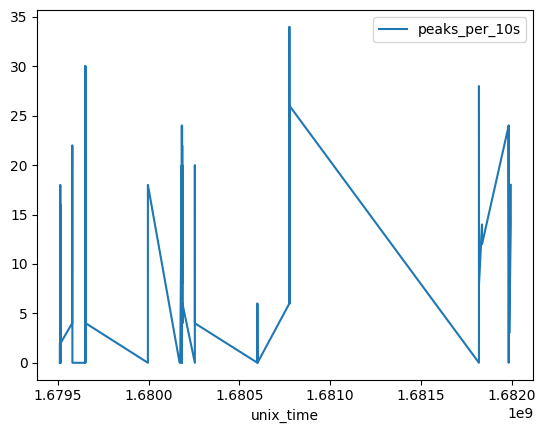

In [46]:
# Plot 'peaks_per_10s' for rows where 'intrusion' is 1
intrusion_df = merged_df[merged_df['intrusion'] == 1]
intrusion_df.plot(x='unix_time', y='peaks_per_10s')

# Find the mean of 'peaks_per_10s' for rows where 'intrusion' is 1
print(intrusion_df['peaks_per_10s'].describe())

# Set an arbitary minimum at 8 peaks per 10 seconds, count how many intrusions are above that threshold
print(intrusion_df[intrusion_df['peaks_per_10s'] > 6].shape)


In [55]:
# For 'intrusion' values
print("All intrusion samples:", merged_df[merged_df['intrusion'].isin([0, 1]) & (merged_df['peaks_per_10s'] > 8)].shape[0])
print("Positive intrusion samples:", merged_df[(merged_df['intrusion'] == 1) & (merged_df['peaks_per_10s'] > 8)].shape[0])
print("Negative intrusion samples:", merged_df[(merged_df['intrusion'] == 0) & (merged_df['peaks_per_10s'] > 8)].shape[0])

# For 'intrusion_nothink' values
print("All intrusion_nothink samples:", merged_df[merged_df['intrusion_nothink'].isin([0, 1]) & (merged_df['peaks_per_10s'] > 8)].shape[0])
print("Positive intrusion_nothink samples:", merged_df[(merged_df['intrusion_nothink'] == 1) & (merged_df['peaks_per_10s'] > 8)].shape[0])
print("Negative intrusion_nothink samples:", merged_df[(merged_df['intrusion_nothink'] == 0) & (merged_df['peaks_per_10s'] > 8)].shape[0])

# For 'intrusion_tnt' values
print("All intrusion_tnt samples:", merged_df[merged_df['intrusion_tnt'].isin([0, 1]) & (merged_df['peaks_per_10s'] > 8)].shape[0])
print("Positive intrusion_tnt samples:", merged_df[(merged_df['intrusion_tnt'] == 1) & (merged_df['peaks_per_10s'] > 8)].shape[0])
print("Negative intrusion_tnt samples:", merged_df[(merged_df['intrusion_tnt'] == 0) & (merged_df['peaks_per_10s'] > 8)].shape[0])



All intrusion samples: 1890482
Positive intrusion samples: 176
Negative intrusion samples: 1890306
All intrusion_nothink samples: 566
Positive intrusion_nothink samples: 176
Negative intrusion_nothink samples: 390
All intrusion_tnt samples: 1103
Positive intrusion_tnt samples: 176
Negative intrusion_tnt samples: 927


In [63]:
merged_df.head()

,acc_x,acc_y,acc_z,temp,eda,bvp,hr,datetime,unix_time,source,peaks,peaks_per_10s,trialcode,response,intrusion,intrusion_nothink,intrusion_tnt
0,-8.000,46.000,48.000,26.450,0.027,61.930,85.000,2023-03-22 12:05:18.000000,1679486718.000,pp3-d1-1,NaN,NaN,None,0,0,NaN,NaN
1,-7.407,46.880,50.649,26.466,0.025,90.600,84.979,2023-03-22 12:05:18.015625,1679486718.016,pp3-d1-1,NaN,NaN,None,0,0,NaN,NaN
2,-6.000,46.000,47.000,26.480,0.022,100.070,84.952,2023-03-22 12:05:18.031250,1679486718.031,pp3-d1-1,NaN,NaN,None,0,0,NaN,NaN
3,-5.865,44.045,42.881,26.493,0.020,89.910,84.919,2023-03-22 12:05:18.046875,1679486718.047,pp3-d1-1,NaN,NaN,None,0,0,NaN,NaN
4,-7.000,44.000,43.000,26.503,0.018,64.680,84.881,2023-03-22 12:05:18.062500,1679486718.062,pp3-d1-1,NaN,NaN,None,0,0,NaN,NaN


In [64]:
# Save with peaks
merged_df.to_csv('output/empatica_inquisit_merged_with_peaks.csv', index=False)

# Save without peaks
merged_df.drop(columns=['peaks_per_10s', 'peaks']).to_csv('output/empatica_inquisit_merged.csv', index=False)